# Experiments Exploratory Data Analysis

## Simple setup
To use the `src` module inside of the notebooks:

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import janitor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss

import src # Load custom functions.

## Load data

In [3]:
experiment_files = list(src.data_raw_dir().rglob("*.zip"))
experiment_ids = list(map(lambda x: x.stem, experiment_files)); experiment_ids

['plasmid_lineages', 'chromosome_lineages']

In [4]:
df = (
    src.read_experiments(
        experiment_files=experiment_files,
        experiment_ids=experiment_ids
    )
    .clean_experiment_names()
    .remove_columns(column_names="unnamed_0")
    .center_frames(by="experiment_id", frame_col="frame")
)
df.head()

,lineage_id,track_id,cell_id,mother_id,frame,roi_id,length,division,dead,gfp,dsred,file_name_id,experiment_id
0,0.0,10.8-34.0,10.8,10.8,0,roi_f10_n8_x129_y214,25.849682,0.0,0.0,120.110,108.394,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
1,0.0,10.8-34.0,11.6,10.8,1,roi_f11_n6_x126_y216,41.415207,1.0,0.0,120.289,108.422,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
2,0.0,10.8-34.0,12.8,10.8,2,roi_f12_n8_x122_y225,19.348009,0.0,0.0,119.765,107.959,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
3,0.0,10.8-34.0,13.8,10.8,3,roi_f13_n8_x124_y224,26.301427,0.0,0.0,119.771,108.061,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages
4,0.0,10.8-34.0,14.5,10.8,4,roi_f14_n5_x124_y220,26.475045,0.0,0.0,119.718,107.977,MGGT-AMP-Pulse_xy01_lineages_all.csv,chromosome_lineages


## Transform data

In [5]:
tidy_df = df.pivot_longer(column_names=["length", "gfp", "dsred"])
tidy_df.head()

,cell_id,dead,division,experiment_id,file_name_id,frame,lineage_id,mother_id,roi_id,track_id,variable,value
0,10.8,0.0,0.0,chromosome_lineages,MGGT-AMP-Pulse_xy01_lineages_all.csv,0,0.0,10.8,roi_f10_n8_x129_y214,10.8-34.0,length,25.849682
1,10.8,0.0,0.0,chromosome_lineages,MGGT-AMP-Pulse_xy01_lineages_all.csv,0,0.0,10.8,roi_f10_n8_x129_y214,10.8-34.0,gfp,120.110000
2,10.8,0.0,0.0,chromosome_lineages,MGGT-AMP-Pulse_xy01_lineages_all.csv,0,0.0,10.8,roi_f10_n8_x129_y214,10.8-34.0,dsred,108.394000
3,11.6,0.0,1.0,chromosome_lineages,MGGT-AMP-Pulse_xy01_lineages_all.csv,1,0.0,10.8,roi_f11_n6_x126_y216,10.8-34.0,length,41.415207
4,11.6,0.0,1.0,chromosome_lineages,MGGT-AMP-Pulse_xy01_lineages_all.csv,1,0.0,10.8,roi_f11_n6_x126_y216,10.8-34.0,gfp,120.289000


In [6]:
stats_df = (
    tidy_df
    .select_columns(["experiment_id", "frame", "variable", "value"])
    .groupby(["experiment_id", "frame", "variable"])
    ["value"]
    .aggregate([
        ("mean", np.mean),
        ("std", np.std),
        ("variation", ss.variation),
        ("skew", ss.skew)
    ])
    .reset_index()
    .pivot_longer(
        column_names=["mean", "std", "variation", "skew"],
        names_to="stat"
    )
)
stats_df.head()

,experiment_id,frame,variable,stat,value
0,chromosome_lineages,0,dsred,mean,108.088855
1,chromosome_lineages,0,dsred,std,0.344442
2,chromosome_lineages,0,dsred,variation,0.003186
3,chromosome_lineages,0,dsred,skew,1.080115
4,chromosome_lineages,0,gfp,mean,121.478737


## Visualize data

### Set plotting defaults

In [7]:
sns.set_style("whitegrid")

plot_defaults = dict(
    sharey="row",
    sharex=True,
    hue="experiment_id",
    height=5.0,
    aspect=1.0
)

### Output directory

In [8]:
out_dir = src.reports_figures_dir; out_dir().relative_to(src.here())

PosixPath('reports/figures')

### Basic observations

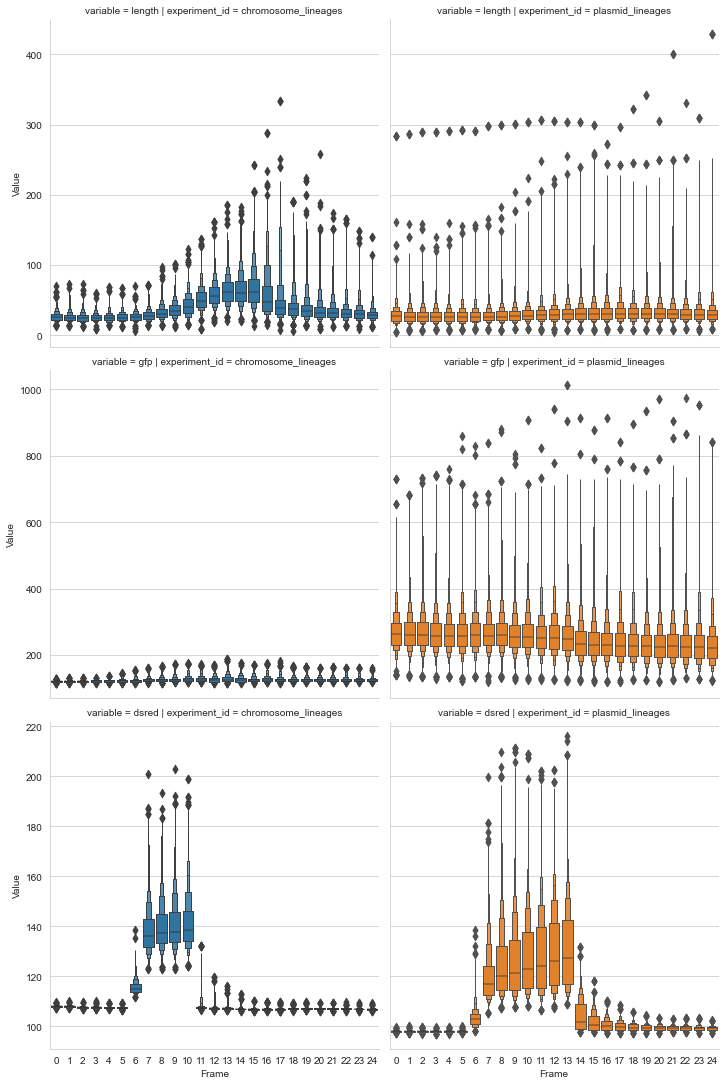

In [9]:
(
    tidy_df
    .experiment_plot(func=sns.boxenplot, **plot_defaults)
    .savefig(out_dir("population_time_overview_boxplot.pdf"))
)

In [10]:
# (
#     tidy_df
#     .experiment_plot(
#         func=sns.lineplot,
#         row="variable",
#         col=None,
#         **plot_defaults
#     )
#     .savefig(out_dir("population_time_overview_lineplot.pdf"))
# )

In [11]:
# #  Don't run since it takes a couple of minutes.
# (
#     tidy_df
#     .experiment_plot(
#         func=sns.lineplot,
#         func_kwargs=dict(
#             units="track_id",
#             legend=False,
#             lw=0.5,
#             estimator=None,
#             alpha=1/5
#         ),
#         **plot_defaults
#     )
#     .savefig(out_dir("individual_time_overview_lineplot.pdf"))
# )

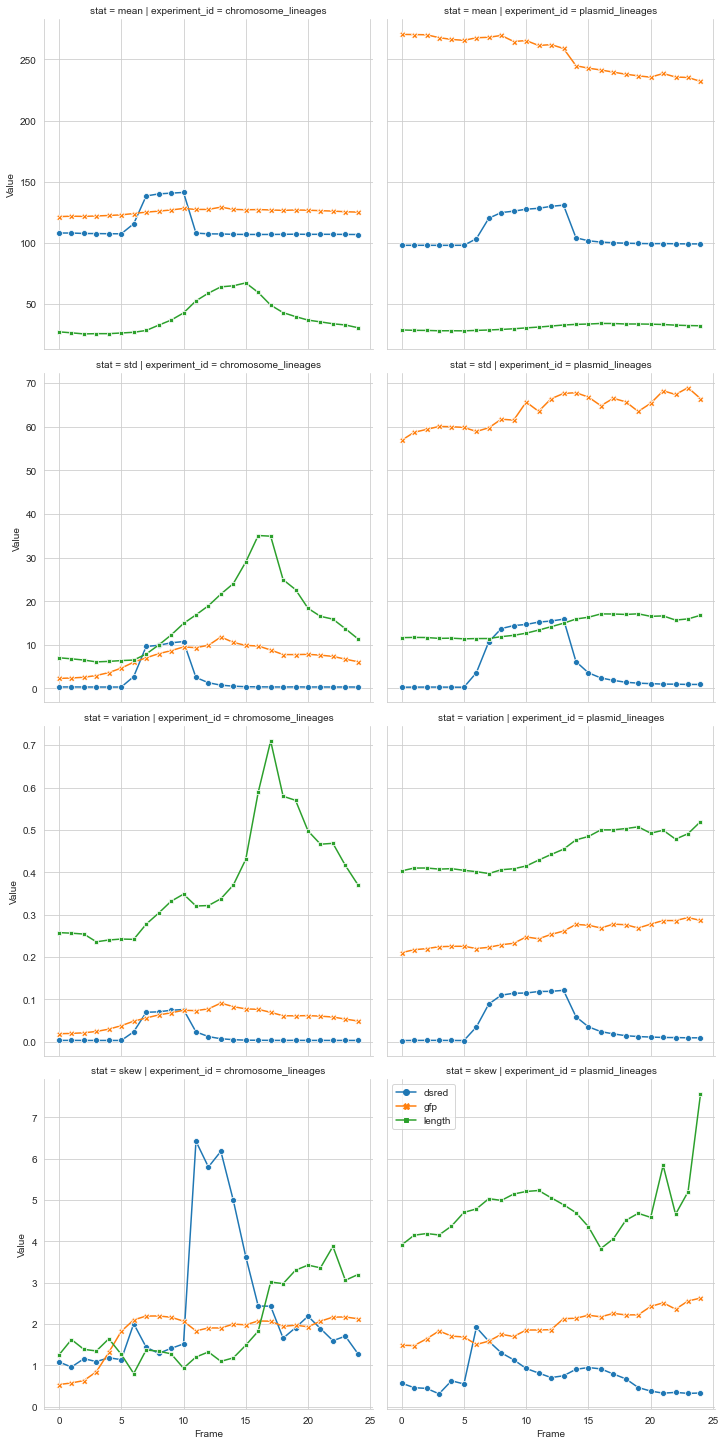

In [12]:
(
    stats_df
    .facet_grid_plot(
        func=sns.lineplot,
        x="frame",
        y="value",
        row="stat",
        col="experiment_id",
        sharey="row",
        height=5.0,
        func_kwargs=dict(
            hue="variable",
            style="variable",
            dashes=False,
            markers=True
        )
    )
    .set_axis_labels("Frame", "Value")
    .savefig(out_dir("basic_stats_time_overview.pdf"))
)
plt.legend();